## Analyzing Sentiments and Geopolitical Stances in Reddit Comments on Israel-Palestine Conflict

## **Introduction:**

In this Kaggle notebook, we delve into the world of online discourse surrounding the Israel-Palestine conflict. By analyzing Reddit comments, our goal is to decipher the sentiments and geopolitical stances of users participating in these discussions. Leveraging Natural Language Processing (NLP) techniques, we embark on a multifaceted journey:

1. **Data Exploration and Cleaning:**
   - We start by loading Reddit comments from a CSV file and employ rigorous data cleaning methods. This includes removing URLs, HTML tags, special characters, and employing lemmatization for text normalization.



2. **Sentiment Analysis:**
   - Utilizing the VADER sentiment analysis tool, we assess the emotional tone of each comment. Four key sentiment metrics—Compound, Positive, Negative, and Neutral—are computed, offering a nuanced understanding of user sentiments.



3. **Exploratory Data Analysis:**
   - Through visualization techniques like density plots and word clouds, we visually represent sentiment distributions. This helps us identify prevailing positive, negative, and neutral sentiments within the dataset.



4. **Topic Modeling:**
   - Employing Latent Dirichlet Allocation (LDA), a popular topic modeling technique, we uncover latent topics within the comments. This step aids in comprehending the underlying themes that dominate the discussions.



5. **Geopolitical Stance Classification:**
   - By combining sentiment scores and dominant topics, we classify comments into distinct geopolitical stances. Users are categorized based on their sentiments—support for Israel, support for Palestine, opposition to Israel/Palestine, or a neutral stance where the user's position remains ambiguous.



6. **Insights and Conclusions:**
   - Through this in-depth analysis, we gain valuable insights into the sentiments and geopolitical inclinations prevalent in Reddit discussions on the Israel-Palestine conflict. This exploration sheds light on the diverse opinions within the online community, providing a comprehensive overview of public sentiment.




In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import numpy as np
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# Read data from CSV file
df = pd.read_csv("/kaggle/input/reddit-on-israel-palestine-daily-updated/pse_isr_reddit_comments.csv")

# Data Exploration and Cleaning

In [3]:
df.sample(5)

comment_id  score                                          self_text  \
400952    k43mu35      1  Meh. I agree with everything you said but Germ...   
184926    k5is0hi      1  Feel free to share it, but I doubt it would mo...   
355148    k4fpq4a     89                                   Doesnt everyone?   
234165    k57nvap      2  Egypt is only going to allow those with dual c...   
341087    k4jse9e    -40             they kept hamas guys in their basement   

                 subreddit               created_time  
400952       AskMiddleEast  2023-10-09 07:05:10+00:00  
184926     IsraelPalestine  2023-10-19 08:50:20+00:00  
355148  NonCredibleDefense  2023-10-11 16:26:39+00:00  
234165     IsraelPalestine  2023-10-17 03:27:09+00:00  
341087      worldnewsvideo  2023-10-12 11:47:49+00:00

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436725 entries, 0 to 436724
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_id    436725 non-null  object
 1   score         436725 non-null  int64 
 2   self_text     436725 non-null  object
 3   subreddit     436725 non-null  object
 4   created_time  436725 non-null  object
dtypes: int64(1), object(4)
memory usage: 16.7+ MB


In [5]:
for i in range(10):
    print(df.self_text[i])

Lol what kind of busted translator device you got. Does it speak only hasbara?
Translation:

Amen. Kill jews and continue gazan oppression!
Friendly fact reminder: Israel has been stealing Palestines land, bombing their civilians, controlling their access to water/food and kidnapping Palestinian civilians for over 50 years. Israel has  been committing genocide on Palestine but somehow people like you like to place the blame on Palestine. If you think Hamas is bad, I have some bad news about the IDF for you.
Well, i would never support Hamas, but there actions Israel could do that would make me stop supporting it: State orginized killing of Israeli or west bank Arabs or use of Atomic weaponary.
/u/TickeMeTendie. This is an automatic notice: 
'Nazis' Casual comments and analogies are inflammatory and therefor not allowed.  
We allow for exemptions for comments with meaningful information that must be based on historical facts accepted by mainstream historians. See [Rule 6](https://www.re

In [6]:
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [7]:
import zipfile
import os

zip_file_path = '/usr/share/nltk_data/corpora/wordnet.zip'
destination_directory = '/usr/share/nltk_data/corpora/'

# Check if the specific file exists in the destination directory
file_to_check = 'index.adv'
file_path_to_check = os.path.join(destination_directory, 'wordnet', file_to_check)

if not os.path.exists(file_path_to_check):
    # Unzip the entire archive if the specific file doesn't exist
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_directory)
    print(f"Successfully unzipped {zip_file_path} to {destination_directory}")
else:
    print(f"File {file_to_check} already exists. No need to unzip the archive.")


Successfully unzipped /usr/share/nltk_data/corpora/wordnet.zip to /usr/share/nltk_data/corpora/


In [8]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    
    # Remove special characters and lowercase the text
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Lemmatization and removing stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Join the tokens back into a sentence
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Example usage on 'self_text' column of your DataFrame
df['clean_text'] = df['self_text'].apply(clean_text)


/tmp/ipykernel_19/2248189783.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [9]:
for i in range(10):
    print(df.clean_text[i])

lol kind busted translator device got speak hasbara
translation amen kill jew continue gazan oppression
friendly fact reminder israel stealing palestine land bombing civilian controlling access waterfood kidnapping palestinian civilian 50 year israel committing genocide palestine somehow people like like place blame palestine think hamas bad bad news idf
well would never support hamas action israel could would make stop supporting state orginized killing israeli west bank arab use atomic weaponary
utickemetendie automatic notice nazi casual comment analogy inflammatory therefor allowed allow exemption comment meaningful information must based historical fact accepted mainstream historian see rule 6 detail bot flag comment using simple word detection distinguish acceptable unacceptable usage please take moment review comment confirm compliance bot action performed automatically please contact moderator subredditmessagecomposetorisraelpalestine question concern
absolutely evidence hamas 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436725 entries, 0 to 436724
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_id    436725 non-null  object
 1   score         436725 non-null  int64 
 2   self_text     436725 non-null  object
 3   subreddit     436725 non-null  object
 4   created_time  436725 non-null  object
 5   clean_text    436725 non-null  object
dtypes: int64(1), object(5)
memory usage: 20.0+ MB


# Sentiment Analysis using VADER

In [11]:
# Initialize the Sentiment Intensity Analyzer
analyzer = SentimentIntensityAnalyzer()

# Declare variables for scores
scores = {
    "Compound": [],
    "Positive": [],
    "Negative": [],
    "Neutral": []
}

# Generate sentiment scores for Reddit comments
for comment in df['clean_text']:
    compound = analyzer.polarity_scores(comment)["compound"]
    pos = analyzer.polarity_scores(comment)["pos"]
    neu = analyzer.polarity_scores(comment)["neu"]
    neg = analyzer.polarity_scores(comment)["neg"]
    
    scores["Compound"].append(compound)
    scores["Positive"].append(pos)
    scores["Negative"].append(neg)
    scores["Neutral"].append(neu)

# Create a new DataFrame for sentiment scores
sentiments_score = pd.DataFrame(scores)

# Join the sentiment scores DataFrame with the original DataFrame
df = pd.concat([df, sentiments_score], axis=1)


In [12]:
df.head()

comment_id  score                                          self_text  \
0    k70vrzb      1  Lol what kind of busted translator device you ...   
1    k70vk4r      1  Translation:\n\nAmen. Kill jews and continue g...   
2    k70vhew      1  Friendly fact reminder: Israel has been steali...   
3    k70ve4h      1  Well, i would never support Hamas, but there a...   
4    k70vay1      1  /u/TickeMeTendie. This is an automatic notice:...   

         subreddit               created_time  \
0  IsraelPalestine  2023-10-29 23:59:03+00:00   
1  IsraelPalestine  2023-10-29 23:57:29+00:00   
2  IsraelPalestine  2023-10-29 23:56:58+00:00   
3  IsraelPalestine  2023-10-29 23:56:18+00:00   
4  IsraelPalestine  2023-10-29 23:55:42+00:00   

                                          clean_text  Compound  Positive  \
0  lol kind busted translator device got speak ha...    0.7351     0.508   
1  translation amen kill jew continue gazan oppre...   -0.6908     0.000   
2  friendly fact reminder israel stealing palesti...   -0.6808     0.195   
3  well would never support hamas action israel c...   -0.5938     0.162   
4  utickemetendie automatic notice nazi casual co...    0.8402     0.238   

   Negative  Neutral  
0     0.000    0.492  
1     0.439    0.561  
2     0.270    0.535  
3     0.287    0.551  
4     0.048    0.714

In [13]:
# Define conditions for sentiment categories based on 'Compound' scores
# If Compound score is <= -0.5, classify as 'Negative'
# If Compound score is > -0.5 and < 0.5, classify as 'Neutral'
# If Compound score is >= 0.5, classify as 'Positive'
conditions = [
    (df['Compound'] <= -0.5),
    (df['Compound'] > -0.5) & (df['Compound'] < 0.5),
    (df['Compound'] > 0.5)
]

# Define corresponding values for each condition
values = ['Negative', 'Neutral', 'Positive']

# Create a new column 'Category' using np.select to assign values based on the conditions
df['Category'] = np.select(conditions, values)

In [14]:
df.head()

comment_id  score                                          self_text  \
0    k70vrzb      1  Lol what kind of busted translator device you ...   
1    k70vk4r      1  Translation:\n\nAmen. Kill jews and continue g...   
2    k70vhew      1  Friendly fact reminder: Israel has been steali...   
3    k70ve4h      1  Well, i would never support Hamas, but there a...   
4    k70vay1      1  /u/TickeMeTendie. This is an automatic notice:...   

         subreddit               created_time  \
0  IsraelPalestine  2023-10-29 23:59:03+00:00   
1  IsraelPalestine  2023-10-29 23:57:29+00:00   
2  IsraelPalestine  2023-10-29 23:56:58+00:00   
3  IsraelPalestine  2023-10-29 23:56:18+00:00   
4  IsraelPalestine  2023-10-29 23:55:42+00:00   

                                          clean_text  Compound  Positive  \
0  lol kind busted translator device got speak ha...    0.7351     0.508   
1  translation amen kill jew continue gazan oppre...   -0.6908     0.000   
2  friendly fact reminder israel stealing palesti...   -0.6808     0.195   
3  well would never support hamas action israel c...   -0.5938     0.162   
4  utickemetendie automatic notice nazi casual co...    0.8402     0.238   

   Negative  Neutral  Category  
0     0.000    0.492  Positive  
1     0.439    0.561  Negative  
2     0.270    0.535  Negative  
3     0.287    0.551  Negative  
4     0.048    0.714  Positive

# Exploratory Data Analysis

In [15]:
# Group the DataFrame by 'Category' and count the occurrences of each category
category_counts = df.groupby(['Category'])['Category'].count()

# Create a DataFrame with counts and rename the column to 'Counts'
counts_df = pd.DataFrame(category_counts).rename(columns={"Category": "Counts"})

# Calculate the percentage for each category and add it as a new column 'Percentage'
counts_df['Percentage'] = (counts_df['Counts'] / counts_df['Counts'].sum()) * 100

counts_df = counts_df.drop(index='0')

# Print or return the summary DataFrame
print(counts_df)

          Counts  Percentage
Category                    
Negative  123092   28.185242
Neutral   247471   56.665178
Positive   66146   15.145916


In [16]:
counts_df

Counts  Percentage
Category                    
Negative  123092   28.185242
Neutral   247471   56.665178
Positive   66146   15.145916

### Pie Chart of Sentiment Counts

In [17]:
import plotly.express as px

# Create a Pie Chart using Plotly
fig = px.pie(counts_df, values='Counts', names=counts_df.index, 
             labels={'Category': 'Sentiment Category', 'Counts': 'Count'},
             title='Distribution of Sentiment Categories in Comments',
             hole=0.3, 
             color_discrete_sequence=px.colors.qualitative.Set1)

# Set the background color of the Pie Chart to dark grey
fig.update_layout(paper_bgcolor='darkgrey')


# Show the Plotly Pie Chart
fig.show()


### Positive Score Comments

In [18]:
# Select the top 50 comments with the highest 'Compound' scores from the DataFrame
top_50_pos_comments = df.nlargest(n=50, columns=['Compound'])["clean_text"]

# This line selects the top 50 comments based on their 'Compound' scores,
# indicating the 50 comments with the most positive sentiment.


print(top_50_pos_comments)

# print top 5
# for com in top_50_pos_comments:
#     print(com, "\n")


84685     yes yes yes yes yes yes yes yes yes yes yes ye...
361366    interested response letter dr theodore herz yo...
95240     following chance commence short term however p...
21719     usa often praised land free uk supposed look f...
90268     great great great great great great great grea...
61924     3 whats education system like community palest...
153529    fair discord im like niche little fandom disco...
211703    government lost control yael sherer indefatiga...
71828     may true achieving peace complex conflict like...
12266     love looking towards future past dont know any...
220155    dont think israeli government want peace hamas...
349945    joke still talking happened 2000 year ago roma...
402525    several indian organization support twostate s...
70942     never offensive war palestinian time got invol...
402594    several british organization support twostate ...
39798     thanks effort made explaine point view speakin...
46216     matter never resolved lifetime

### Negative Score Comments

In [19]:
# Select the top 50 comments with the highest 'Compound' scores from the DataFrame
top_50_neg_comments = df.nsmallest(n=50, columns=['Compound'])["clean_text"]

print(top_50_neg_comments)

## print top 5
# for com in top_50_neg_comments:
#     print(com, "\n")

24864     dont say really mean dont damn jew allow die i...
24868     dont say really mean dont damn jew allow die i...
32958     israel bomb hamas target gaza recklessly endan...
98456     dont say really mean dont damn jew allow die i...
101018    long please read albeit warned nsfl descriptio...
314078    lol historical record genetics prove invasion ...
340637    there also still hangover 911 paris 2015 littl...
60586     israel jewish state entire world change fact c...
93270     article text behind paywallsorry formatting is...
148708    respond hospital fallacy disproven beyond doub...
292230    anyone saying idf isnt responsible happened 19...
12368     people city something dont like mean point bla...
46222     think cant copy full article behind paywall he...
73676     war crime actually term definition legal struc...
105578    follows pattern child victim abuse generally g...
242493    see table whether accurate idea let assume vas...
249450    yes hamas clearly committed fo

### Comments With High Upvotes

In [20]:
# Sort the DataFrame by 'score' in descending order and select unique 'clean_text' values
top_50_high_score_comments = df.sort_values('score', ascending=False)['clean_text'].drop_duplicates().head(50)

# This line sorts the DataFrame by 'score' in descending order, 
# selects unique 'clean_text' values, and retrieves the top 50 comments 
# with the highest scores.

print(top_50_high_score_comments)

# # print top 5
# for com in top_50_high_score_comments:
#     print(com, "\n")

355485    thats pretty damning netanyahu israeli intelli...
341434    israel said would humanitarian break siege gaz...
220023    could get source affiliated either israel pale...
54889                       thats odd way ask regime change
435128                       weekend going ugly middle east
429377                                  going end well shit
71376     whatever one thought outlet journalist reporti...
28778     wouldnt emergency response time live even woul...
205179    there lot people waited fact instead reactiona...
88547     went say grievance palestinian people justify ...
314859    palestinian people theyre victim didnt ask did...
370903     shockingly easy go life without beheading anyone
283804                       giving south park sorry energy
355436    disaster dont see netanyahus career ever going...
340554                           til reuters reddit account
110150    among still image included raw footage reel de...
206949    biggest plot twist none u expe

### Comments With Low Upvotes

In [21]:
top_50_low_score_comments = df.sort_values('score', ascending=True)['clean_text'].drop_duplicates().head(50)
print(top_50_low_score_comments)

221507    yeah change idf came saidnthey already warned ...
436406       bad pretty much pointless fire thousand rocket
312415                        actual proven military target
6730      making biblical reference killing innocent peo...
70019                              yeah dozen civilian area
242531    necessarily targeting civilian typically crime...
113465                                             dont idf
436376    defensive approach taken using iron dome exact...
160848    first part accurate second part astonishingly ...
221304    know anything conflict would know home made mi...
59818     israel leave tail tucked proclaim defeated ham...
431181                                           gentle smh
105479    example delusional left israel helping gazan p...
310939    theyre western pressure desire keep peace deal...
329382    food water medicine electricity hit childrens ...
286905    hard justify anybody saying idf made mistake d...
431471    claim better one call terroris

### Visualization of the Sentiment Scores of Positive, Neutral & Negative Tweets

/tmp/ipykernel_19/3568289118.py:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2511: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_19/3568289118.py:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new 

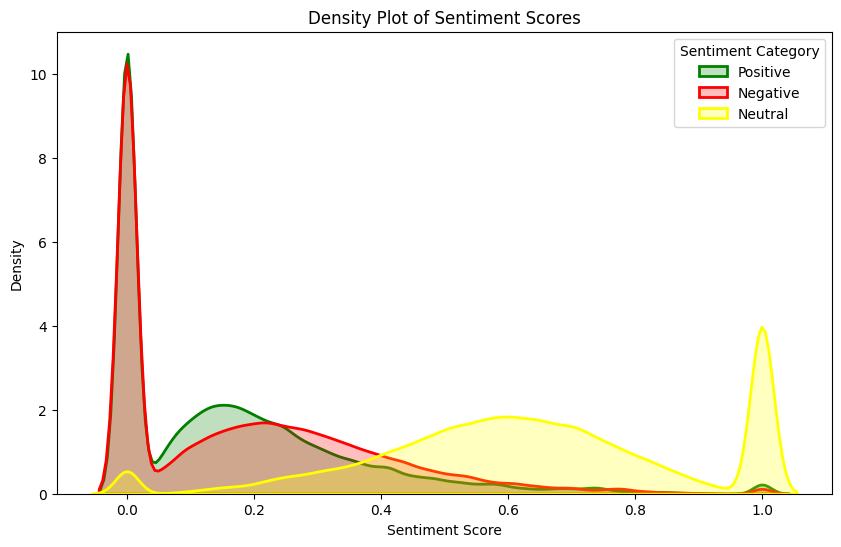

In [22]:
# Define the sentiment categories and corresponding colors
sentiment_categories = ["Positive", "Negative", "Neutral"]
colors = ['green', 'red', 'yellow']

# Set up the plot
plt.figure(figsize=(10, 6))

# Iterate over sentiment categories and plot KDE
for category, color in zip(sentiment_categories, colors):
    sns.distplot(df[category], hist=False, kde=True,
                 bins=int(180/5), color=color,
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'shade': True, 'linewidth': 2}, label=category)

# Set plot labels and legend
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Scores')
plt.legend(title='Sentiment Category')

# Show the plot
plt.show()


### Visualization of the Sentiment Scores

/tmp/ipykernel_19/1808040337.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2511: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




<Axes: xlabel='Compound', ylabel='Density'>

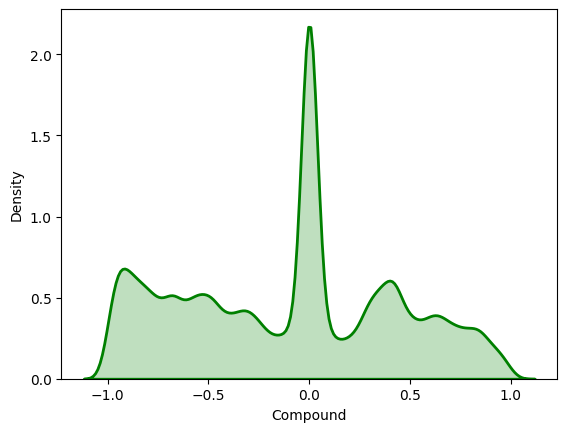

In [23]:
sns.distplot(df["Compound"], hist=False, kde=True, 
             bins=int(180/5), color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

### WordCloud of All Sentiments

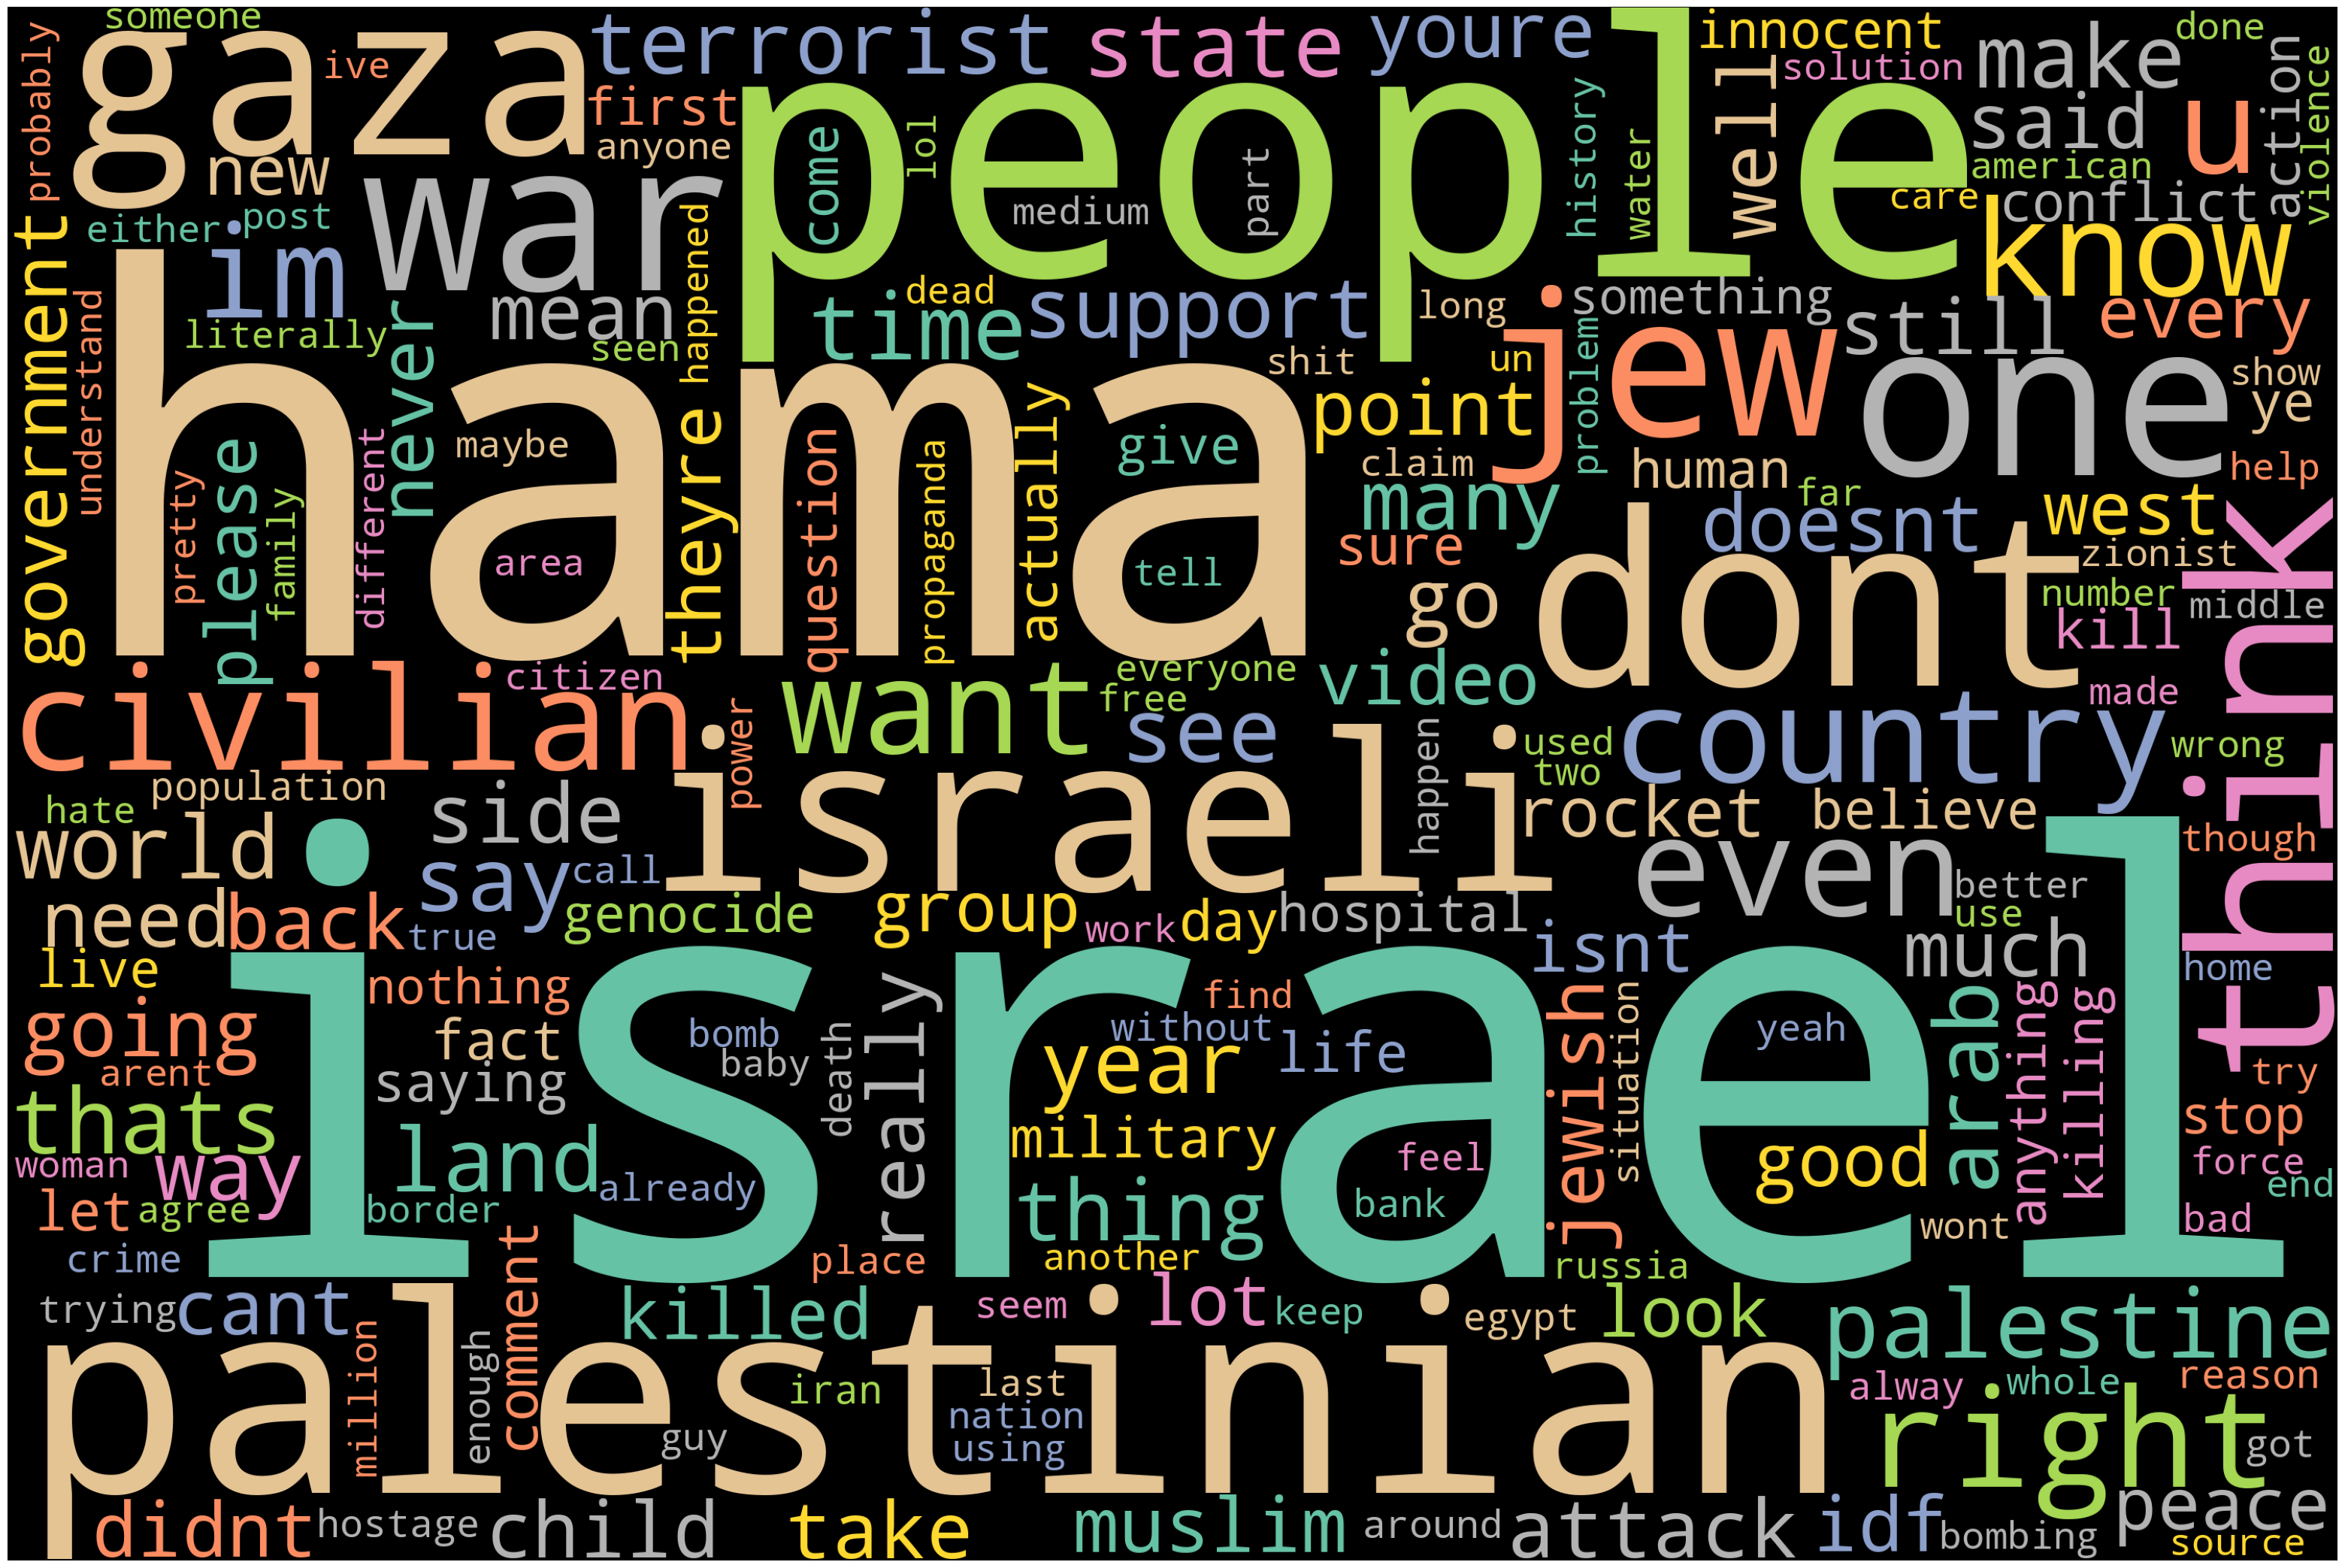

In [24]:
# Concatenate all comments into a single string
text = " ".join(comment for comment in df.clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(40, 30))

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


### WordCloud of Positive Sentiments

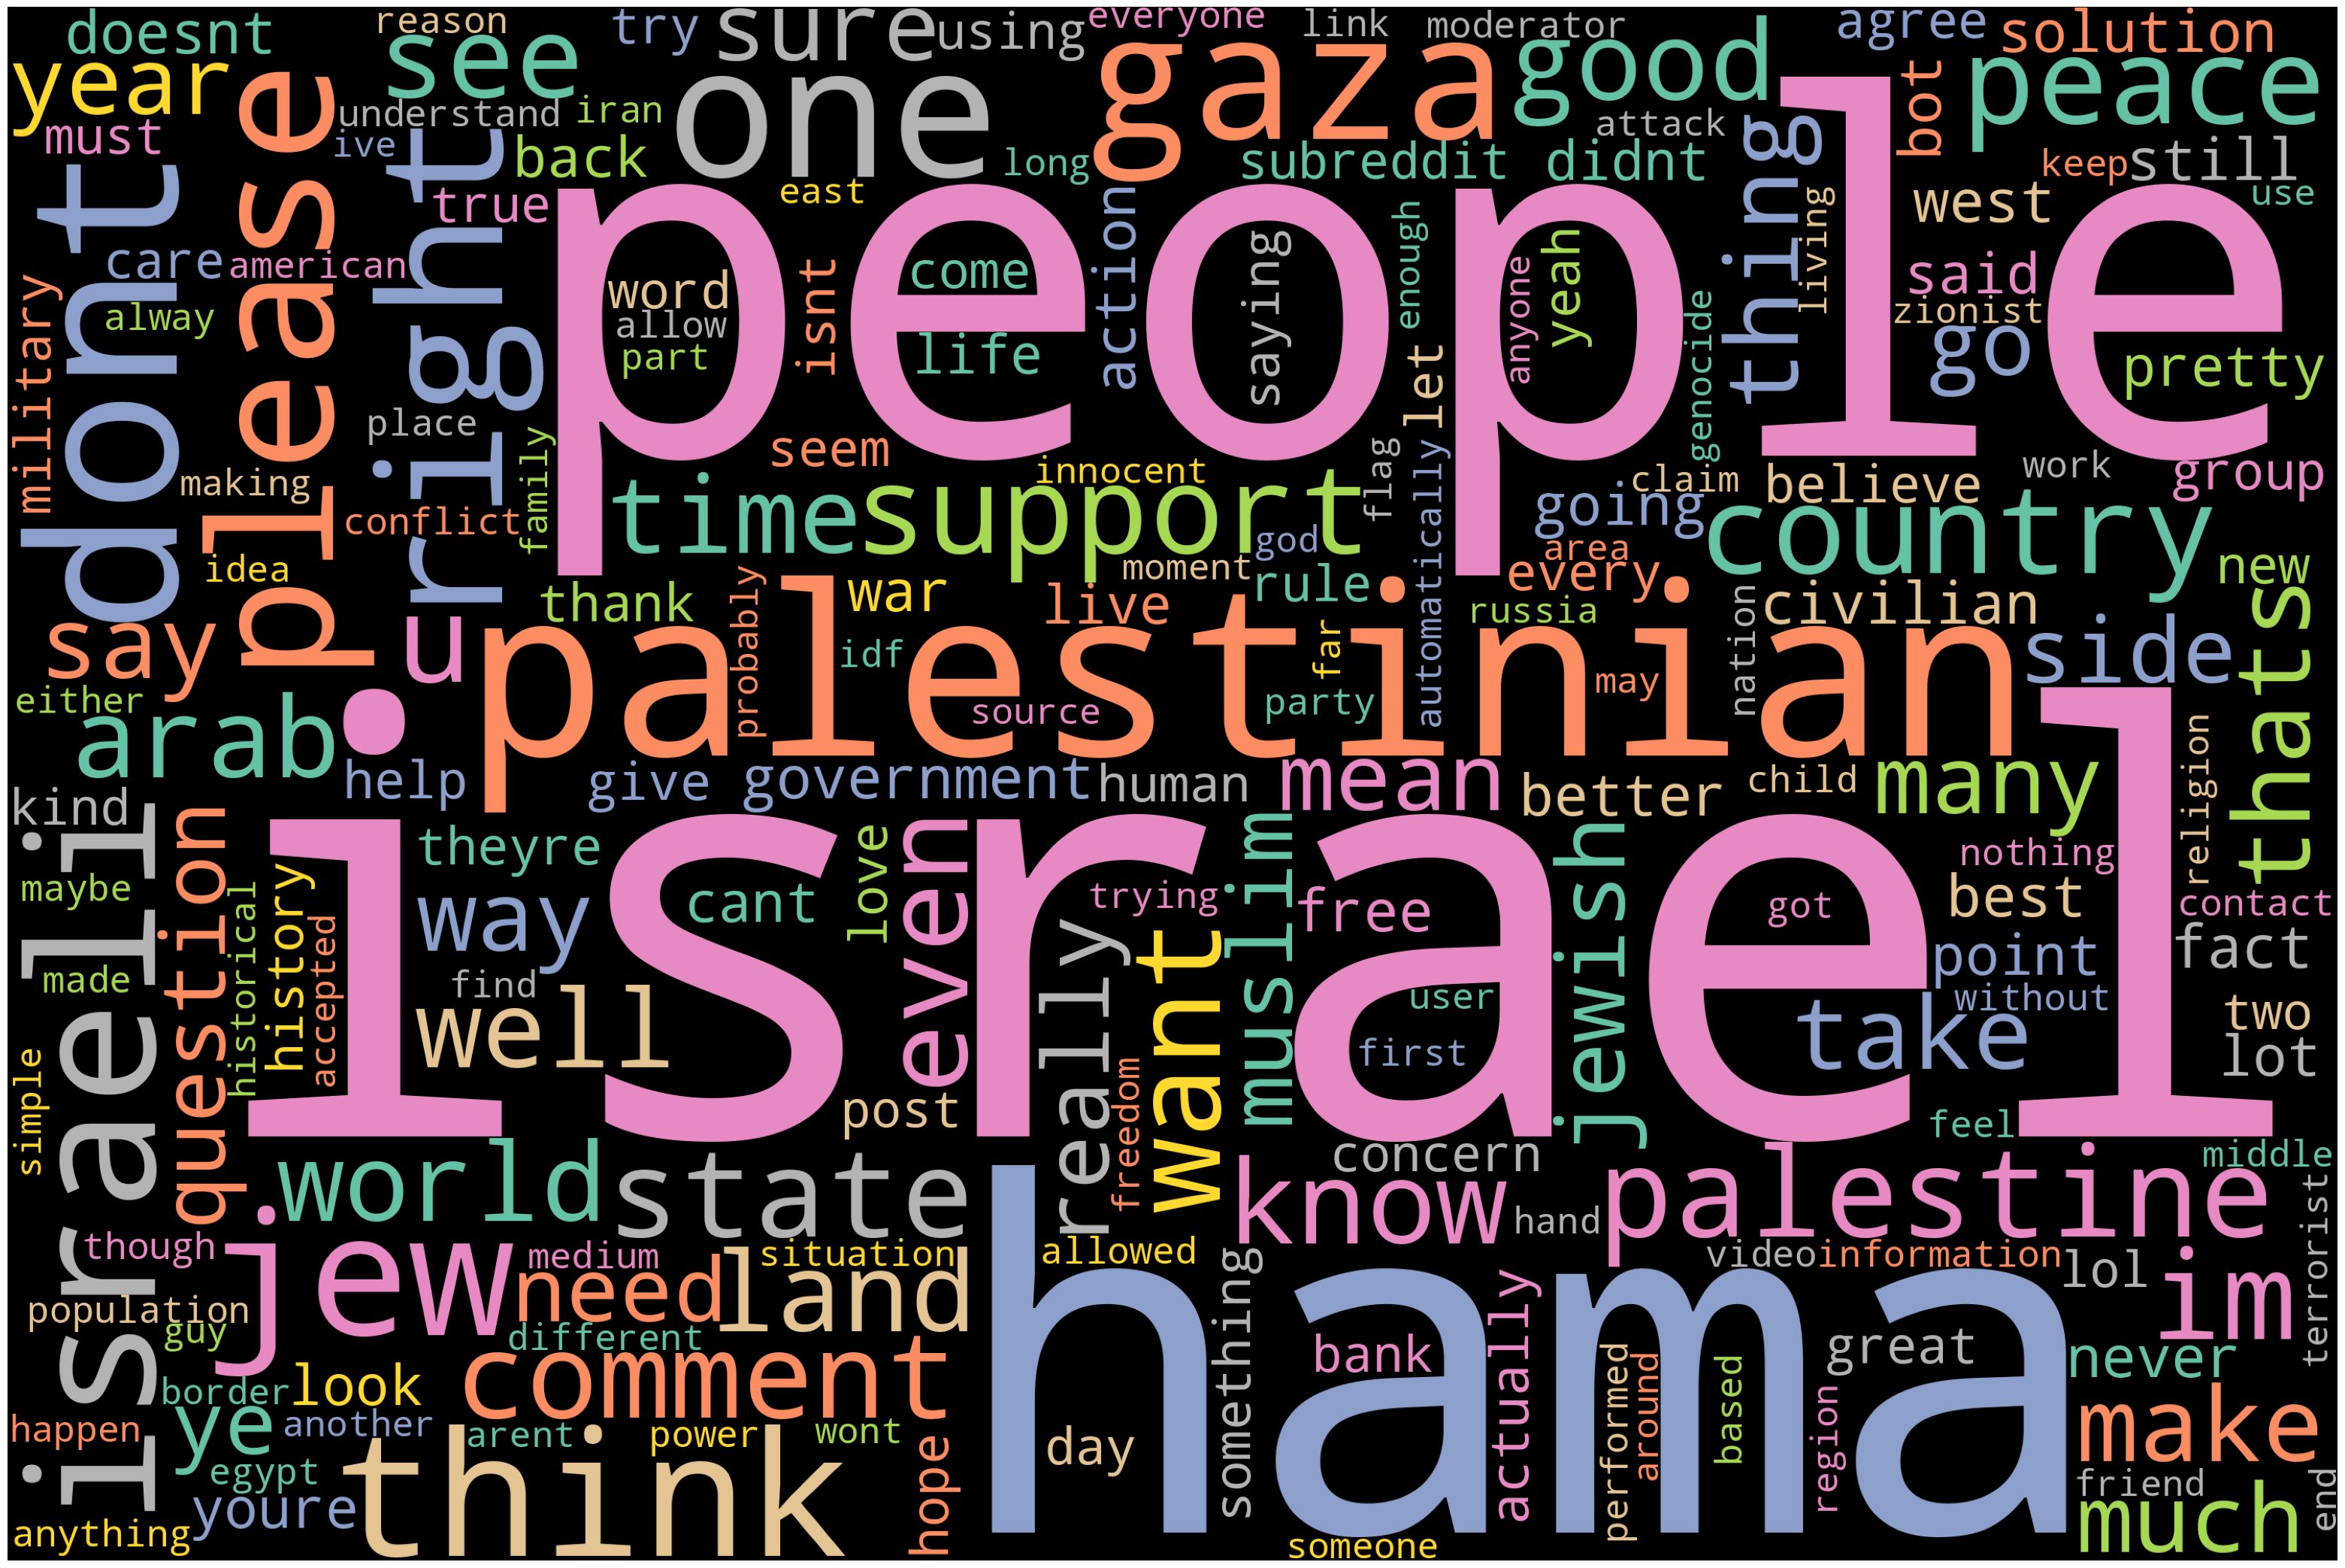

In [25]:
# Concatenate all comments into a single string
text = " ".join(comment for comment in df[df['Category']=='Positive'].clean_text)
                                            
# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(40, 30))

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


### WordCloud of Neutral Sentiments

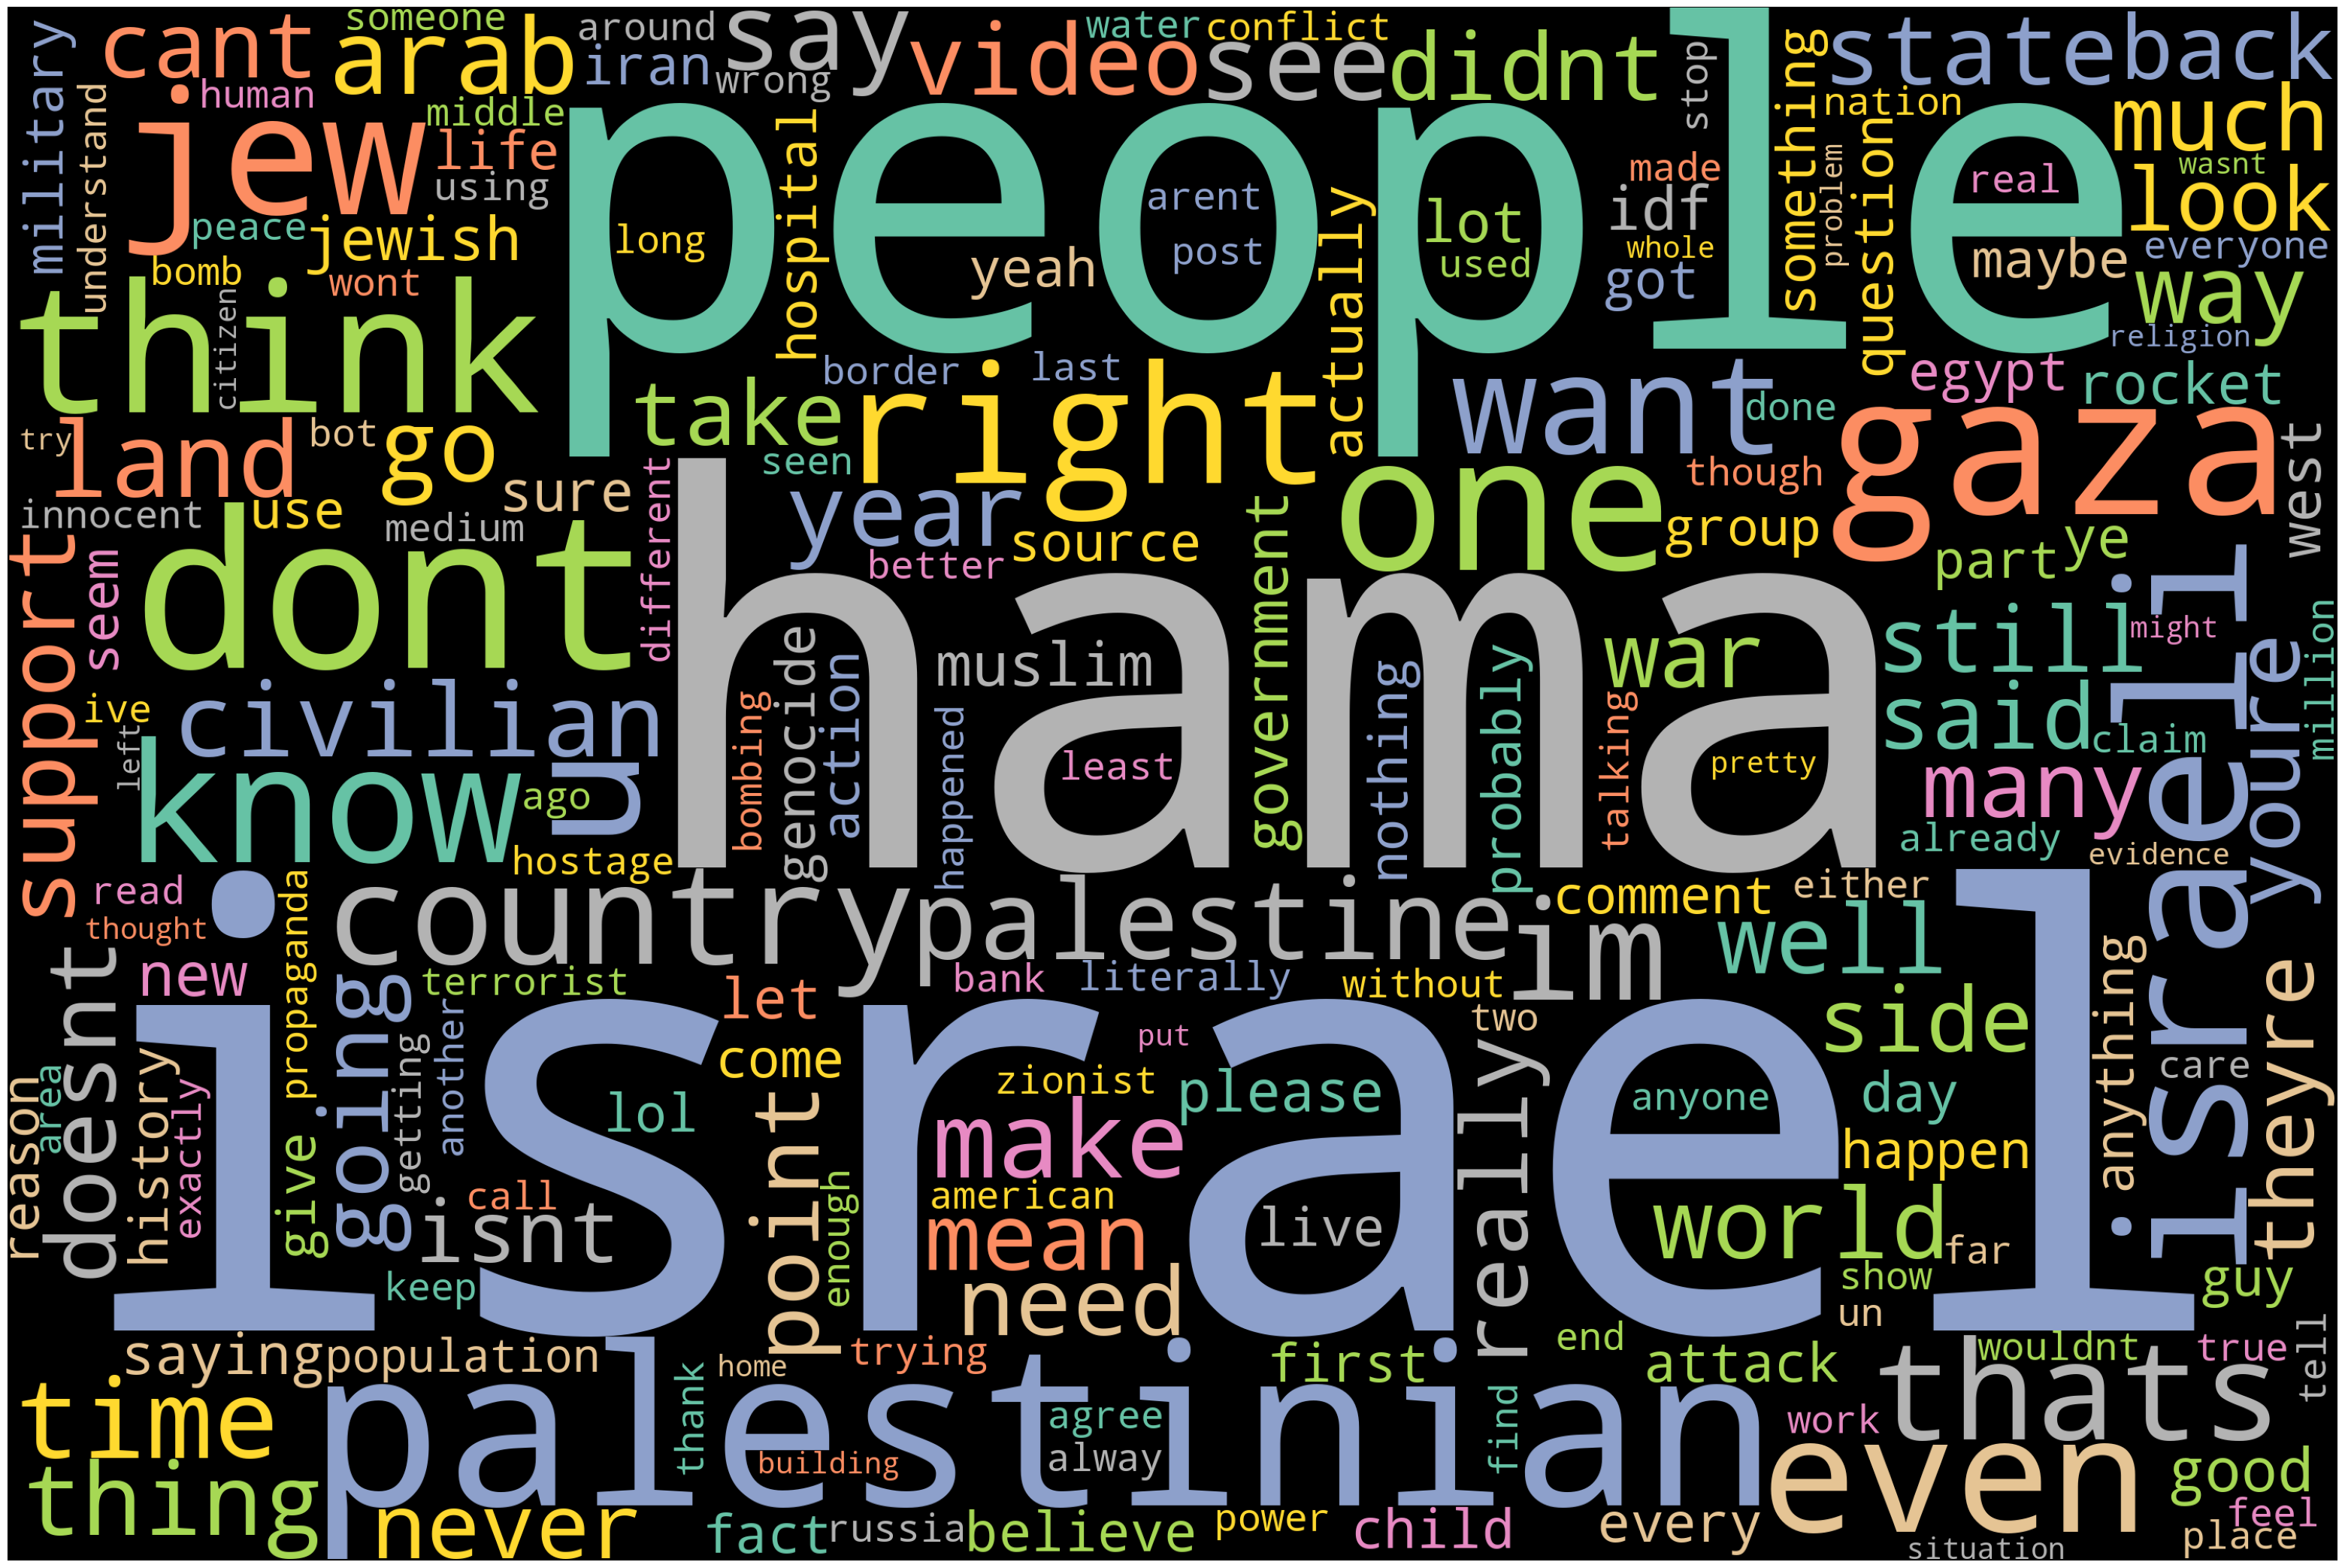

In [26]:
# Concatenate all comments into a single string
text = " ".join(comment for comment in df[df['Category']=='Neutral'].clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(40, 30))

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


### WordCloud of Negative Sentiments

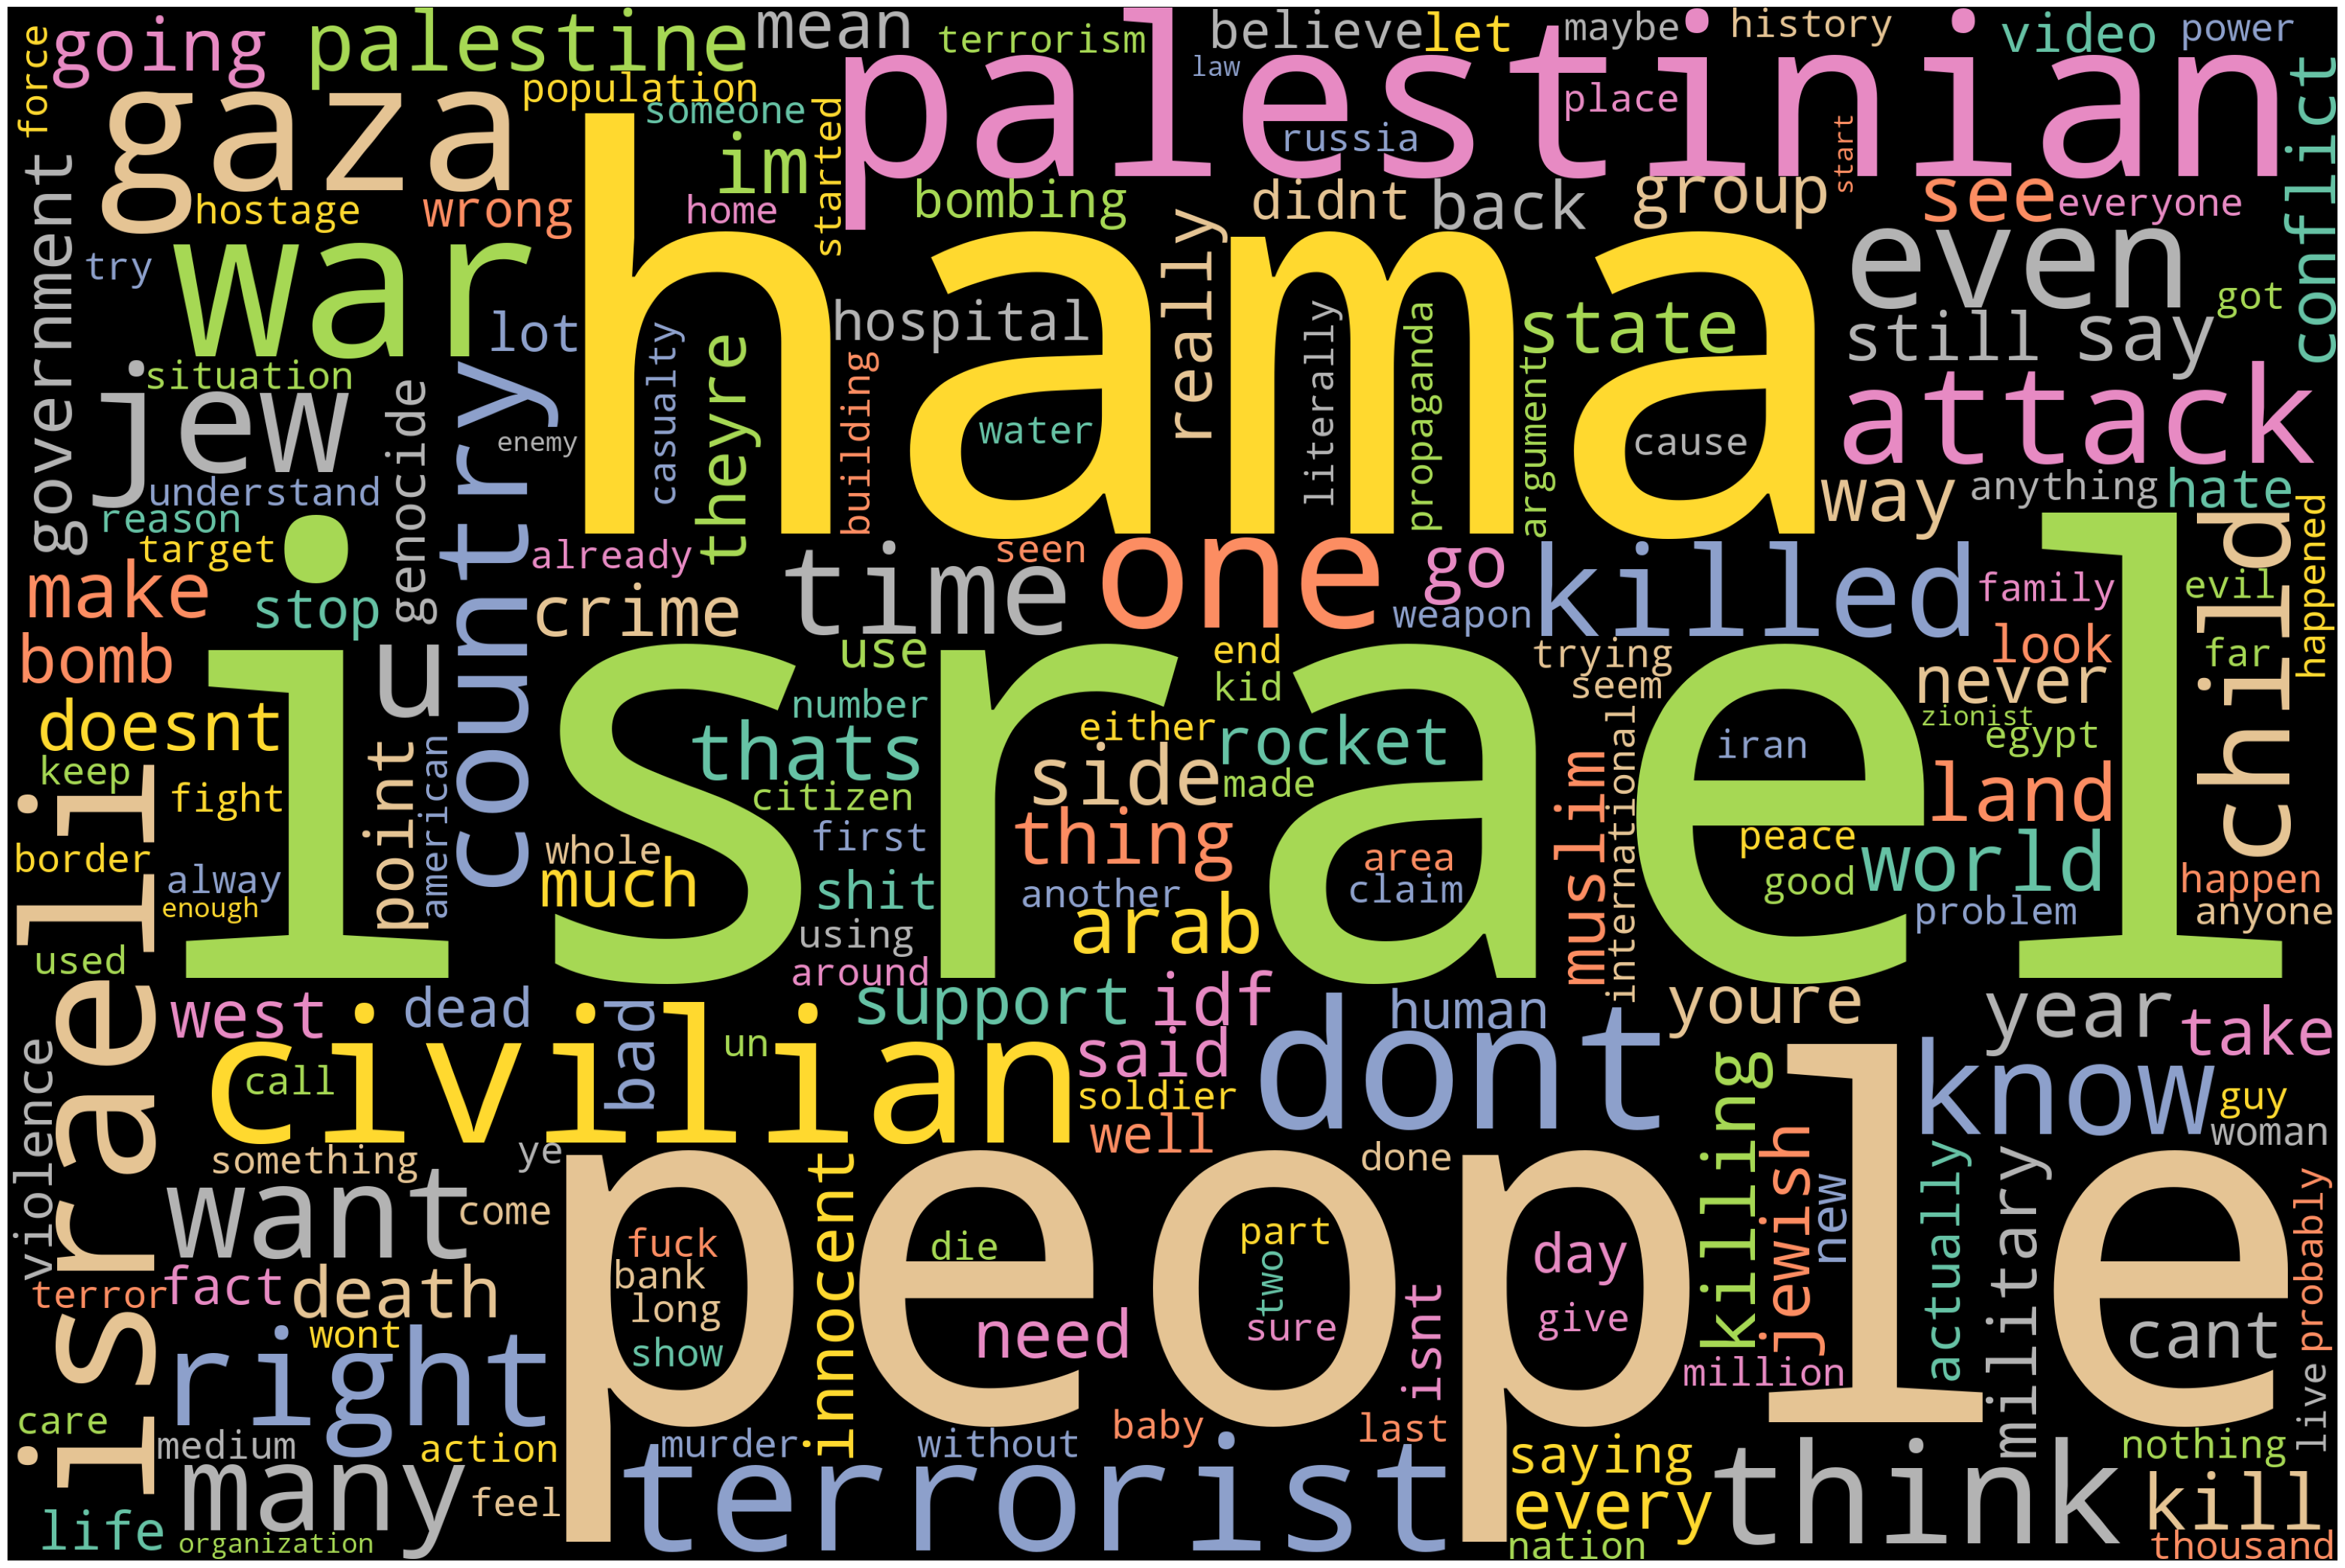

In [27]:
# Concatenate all comments into a single string
text = " ".join(comment for comment in df[df['Category']=='Negative'].clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(40, 30))

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436725 entries, 0 to 436724
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   comment_id    436725 non-null  object 
 1   score         436725 non-null  int64  
 2   self_text     436725 non-null  object 
 3   subreddit     436725 non-null  object 
 4   created_time  436725 non-null  object 
 5   clean_text    436725 non-null  object 
 6   Compound      436725 non-null  float64
 7   Positive      436725 non-null  float64
 8   Negative      436725 non-null  float64
 9   Neutral       436725 non-null  float64
 10  Category      436725 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 36.7+ MB


In [29]:
df.head()

comment_id  score                                          self_text  \
0    k70vrzb      1  Lol what kind of busted translator device you ...   
1    k70vk4r      1  Translation:\n\nAmen. Kill jews and continue g...   
2    k70vhew      1  Friendly fact reminder: Israel has been steali...   
3    k70ve4h      1  Well, i would never support Hamas, but there a...   
4    k70vay1      1  /u/TickeMeTendie. This is an automatic notice:...   

         subreddit               created_time  \
0  IsraelPalestine  2023-10-29 23:59:03+00:00   
1  IsraelPalestine  2023-10-29 23:57:29+00:00   
2  IsraelPalestine  2023-10-29 23:56:58+00:00   
3  IsraelPalestine  2023-10-29 23:56:18+00:00   
4  IsraelPalestine  2023-10-29 23:55:42+00:00   

                                          clean_text  Compound  Positive  \
0  lol kind busted translator device got speak ha...    0.7351     0.508   
1  translation amen kill jew continue gazan oppre...   -0.6908     0.000   
2  friendly fact reminder israel stealing palesti...   -0.6808     0.195   
3  well would never support hamas action israel c...   -0.5938     0.162   
4  utickemetendie automatic notice nazi casual co...    0.8402     0.238   

   Negative  Neutral  Category  
0     0.000    0.492  Positive  
1     0.439    0.561  Negative  
2     0.270    0.535  Negative  
3     0.287    0.551  Negative  
4     0.048    0.714  Positive

# Positive or Negative Bias Detection

In [30]:
# Calculate the average sentiment scores for each subreddit
subreddit_sentiment = df.groupby('subreddit')[['Positive', 'Negative']].mean()

# Calculate the difference between positive and negative sentiment scores
subreddit_sentiment['Bias'] = subreddit_sentiment['Positive'] - subreddit_sentiment['Negative']

# Determine the direction of bias: Positive, Negative, or Neutral
def determine_bias_direction(bias):
    if bias > 0.01:  # You can adjust this threshold based on your dataset
        return 'Positive'
    elif bias < -0.01:  # You can adjust this threshold based on your dataset
        return 'Negative'
    else:
        return 'Neutral'

subreddit_sentiment['Bias Direction'] = subreddit_sentiment['Bias'].apply(determine_bias_direction)

# Sort subreddits based on bias in descending order
most_biased_subreddits = subreddit_sentiment.sort_values(by='Bias', ascending=False)

# Print or view the most biased subreddits with bias direction
print(most_biased_subreddits)


                       Positive  Negative      Bias Bias Direction
subreddit                                                         
AbruptChaos            0.170791  0.132264  0.038527       Positive
NonCredibleDefense     0.155961  0.147808  0.008152        Neutral
CrazyFuckingVideos     0.162982  0.168266 -0.005284        Neutral
Palestine              0.176340  0.186609 -0.010269       Negative
AskMiddleEast          0.166732  0.182092 -0.015360       Negative
IsraelPalestine        0.166904  0.186300 -0.019397       Negative
CombatFootage          0.157813  0.182511 -0.024698       Negative
worldnews              0.160626  0.186105 -0.025479       Negative
ActualPublicFreakouts  0.177926  0.206657 -0.028731       Negative
worldnewsvideo         0.172257  0.205349 -0.033092       Negative
TerrifyingAsFuck       0.167938  0.203776 -0.035839       Negative
PublicFreakout         0.160095  0.202689 -0.042594       Negative
IsrealPalestineWar_23  0.171626  0.220825 -0.049199       Nega

In [31]:
# Step 3: Topic Modeling
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['clean_text'])
lda_model = LatentDirichletAllocation(n_components=5, random_state=42, n_jobs=-1)  # Assuming 5 topics
lda_topic_matrix = lda_model.fit_transform(tfidf_matrix)

# Topic Modelling

In [32]:
# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the top words for each topic
n_top_words = 10  # You can adjust this number to display more or fewer words per topic
top_words_per_topic = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_words_per_topic.append(top_words)

# Print the topics and associated words
for topic_idx, top_words in enumerate(top_words_per_topic):
    print(f"Topic #{topic_idx + 1}:")
    print(", ".join(top_words))
    print()


Topic #1:
hamas, palestinian, people, israel, terrorist, israeli, civilian, child, dont, support

Topic #2:
land, israel, arab, jew, country, palestinian, year, state, war, like

Topic #3:
israel, hamas, gaza, civilian, war, people, dont, rocket, egypt, iran

Topic #4:
dont, people, im, comment, know, jew, like, youre, think, thank

Topic #5:
video, like, source, lol, hospital, news, hamas, post, look, thats



In [33]:
# Get the vocabulary indices for 'israel' and 'palestine' in your vectorizer
israel_word_index = vectorizer.vocabulary_['israel']
palestine_word_index = vectorizer.vocabulary_['palestine']

In [34]:
topic_term_distribution = lda_model.components_

In [35]:
israel_topic_index = topic_term_distribution[:, israel_word_index].argmax()
palestine_topic_index = topic_term_distribution[:, palestine_word_index].argmax()

In [36]:
# # Extract topic indices from the words associated with 'israel' and 'palestine'
# israel_topic_index = [topic_word[0] for topic_word in israel_topic_words]
# palestine_topic_index = [topic_word[0] for topic_word in palestine_topic_words]

# Geopolitical Stance Determination Using Dominant Topics and Sentiment Scores

In [37]:
# Define the function to determine geopolitical stance
def determine_geopolitical_stance(row):
    sentiment_score = row['Compound']
    topic_distribution = lda_model.transform(vectorizer.transform([row['clean_text']]))[0]
    
    # Determine stance based on sentiment score and dominant topic
    if sentiment_score <= -0.5:
        return 'Against Israel/Palestine'
    elif sentiment_score >= 0.5 and topic_distribution.argmax() == israel_topic_index:
        return 'Supports Israel'
    elif sentiment_score >= 0.5 and topic_distribution.argmax() == palestine_topic_index:
        return 'Supports Palestine'
    else:
        return 'Neutral/Stance Not Clear'

# Apply the function to the DataFrame to determine geopolitical stances
df['geopolitical_stance'] = df.apply(determine_geopolitical_stance, axis=1)

In [38]:
stance_counts = df['geopolitical_stance'].value_counts()
print("Geopolitical Stance Distribution:")
print(stance_counts)

Geopolitical Stance Distribution:
geopolitical_stance
Neutral/Stance Not Clear    286000
Against Israel/Palestine    123092
Supports Palestine           13911
Supports Israel              13722
Name: count, dtype: int64


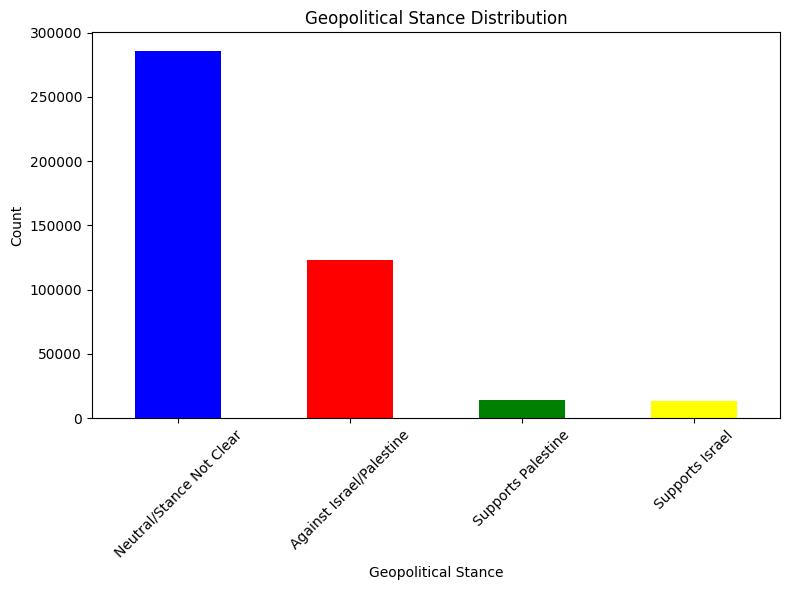

In [39]:
# Assuming 'geopolitical_stance' is a column in your DataFrame df
stance_counts = df['geopolitical_stance'].value_counts()

# Create bar chart using DataFrame values
plt.figure(figsize=(8, 6))
stance_counts.plot(kind='bar', color=['blue', 'red', 'green', 'yellow'])
plt.xlabel('Geopolitical Stance')
plt.ylabel('Count')
plt.title('Geopolitical Stance Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the chart
plt.show()

### Geopolitical Stance Distribution:

- **Neutral/Stance Not Clear:** The majority of the data falls into this category with a count of 286,000. This suggests that a significant portion of the dataset does not express a clear geopolitical stance on the Israel-Palestine issue.

- **Against Israel/Palestine:** There are 123,092 instances where the stance is against Israel/Palestine. This indicates a substantial portion of the data expressing a negative sentiment or opposition towards Israel, Palestine, or both.

- **Supports Palestine:** There are 13,911 instances where the stance supports Palestine. This represents a smaller but notable segment of the data that expresses support for the Palestinian side of the conflict.

- **Supports Israel:** There are 13,722 instances where the stance supports Israel. Similar to supporting Palestine, supporting Israel is also expressed by a smaller but significant portion of the dataset.

In summary, the majority of the data does not express a clear stance. Among those that do, there is a considerable diversity of opinions, with a slightly higher number of instances leaning against Israel/Palestine.


# Inferences

### **Why Neutral or Unclear Stance is Disturbing:**

1. **Humanitarian Crisis:** The war has led to a significant humanitarian crisis, with a large number of civilian casualties, including children. A neutral stance might indicate a lack of active engagement for a peaceful resolution, potentially perpetuating the crisis.

2. **Potential for Change:** A neutral stance might imply a failure to actively work towards a resolution. With so many lives at stake, not actively supporting efforts for peace could be seen as a missed opportunity to make a positive impact.

3. **Moral Responsibility:** Some argue that in the face of significant human suffering, individuals and nations have a moral responsibility to take a stand against violence and advocate for peaceful solutions. A neutral stance might be perceived as shirking this responsibility.

4. **Perpetuation of War:** A lack of active engagement might inadvertently support the status quo, allowing the war to continue without significant international pressure for resolution. This can lead to more lives being lost and the prolongation of suffering.

5. **Missed Opportunities for Diplomacy:** International pressure and diplomacy can play a crucial role in war resolution. By not picking a side, opportunities for diplomatic efforts and negotiations might be missed, hindering the chances of finding a peaceful resolution.

6. **Failure to Address Root Causes:** Taking a neutral stance means avoiding addressing the underlying issues that fuel the war, such as territorial disputes and human rights violations. Without addressing these root causes, long-term peace and stability are impossible to achieve.

7. **Lack of Moral Clarity:** In situations with clear human rights violations, a neutral stance cab be seen as a lack of moral clarity and a failure to stand up against injustice.

In summary, a neutral or complacent stance in the Israel-Palestine war might be perceived as problematic because it can contribute to the continuation of the war and the suffering of those involved. Many advocate for active engagement, dialogue, and efforts toward a peaceful resolution to prevent further loss of lives, especially among vulnerable populations like children.
